# Introduction to Embeddings

This notebook provides a thorough introduction to the concept of embeddings.

## Setup libraries and functions.

We start by importing various libraries needed.

In [1]:
# Plots displayed inline in notebook
%matplotlib inline

# Make Python 3 consistent
from __future__ import print_function, division

# Make help libraries available
import sys

sys.path.append('/home/ubuntu/personal-libraries')

In [52]:
import pandas as pd
import numpy as np

from operator import itemgetter
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Input, Dense, Flatten, merge, Dropout
from keras.layers.merge import dot, add, concatenate
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.optimizers import Adam

from keras import backend as K
K.set_image_data_format('channels_first')

Setup paths and batch size. We work with the movielens dataset, and utilise the small dataset at first.

In [3]:
#path = "data/ml-20m/"
path = "data/movielens/ml-latest-small/"
model_path = 'models/recommender-intro/'

batch_size = 64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [4]:
ratings = pd.read_csv(path + 'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [6]:
movie_names = pd.read_csv(path + 'movies.csv').set_index('movieId')['title'].to_dict()

Define users and movies (as ids)

In [7]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

We define two dictionaries mapping each user and movie to a continous ordered integer.

In [8]:
userid2idx = {o:i for i, o in enumerate(users)}
movieid2idx = {o:i for i, o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [9]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

To get an overview of the structure of the data, we consider the max and min values.

In [10]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
                                            ratings.userId.max(),
                                            ratings.movieId.min(),
                                            ratings.movieId.max())

user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

So we have 671 users mapped to continous IDs and 9066 movies mapped to continous IDs. We check by considering the length of the objects.

In [11]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

We specify the number of latent factors in each embedding. This is a free parameter.

In [12]:
n_factors = 50

In [13]:
# Specify numpy seed, such that we get the same random sample each time
np.random.seed = 42

Randomly split into training and validation.

In [14]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [15]:
g = ratings.groupby('userId')['rating'].count()
topUsers = g.sort_values(ascending = False)[:15]

In [16]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending = False)[:15]

In [17]:
top_r = ratings.join(topUsers, rsuffix = '_r', how = 'inner', on = 'userId')

In [18]:
top_r = top_r.join(topMovies, rsuffix = '_r', how = 'inner', on = 'movieId')

In [19]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc = np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


We can then consider the intuition of collavborative filtering in Excel.

In [20]:
from IPython.display import FileLink
FileLink('collab_filter.xlsx')

/home/ubuntu/deep-learning/embedding-intro/collab_filter.xlsx

## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works. We build two simple embeddings, one for users and one for movies. Note the onedimensional input. Also note that we add regularisation.

In [21]:
user_in = Input(shape=(1, ), dtype = 'int64', name = 'user_in')
u = Embedding(n_users, n_factors, input_length = 1, embeddings_regularizer = l2(1e-4))(user_in)
movie_in = Input(shape=(1, ), dtype = 'int64', name = 'movie_in')
m = Embedding(n_movies, n_factors, input_length = 1, embeddings_regularizer = l2(1e-4))(movie_in)

We then merge the two input layers via the dotproduct of the two. Note in this case of collaborative filtering for recomender systems, we use embeddings of users and movies to save computation time. We could have one hot encoded the layers, but that would gie us giant matrices to multiply. Instead we use an embedding representation.

In [22]:
# Define model layers
# Note that axes has to be set to 2! Remember the order is (batches, channels, dim1)
x = dot([u, m], 2)
x = Flatten()(x)

# Initialise and compile the model
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss = 'mse')

Let's consider the model.

In [23]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

Train the model for a single epoch.

In [24]:
model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 1, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 79939 samples, validate on 20065 samples
Epoch 1/1
79939/79939 [==============================] - 8s - loss: 9.9262 - val_loss: 4.2590


Increase the learning rate and run for 3 more epochs.

In [25]:
model.optimizer.lr = 0.01

model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 3, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 79939 samples, validate on 20065 samples
Epoch 1/3
79939/79939 [==============================] - 8s - loss: 3.1293 - val_loss: 2.7980
Epoch 2/3
79939/79939 [==============================] - 8s - loss: 2.4046 - val_loss: 2.5955
Epoch 3/3
79939/79939 [==============================] - 8s - loss: 2.2380 - val_loss: 2.5512


Finally lower the learning rate again and train for 6 more epochs.

In [26]:
model.optimizer.lr=0.001
model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 6, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 79939 samples, validate on 20065 samples
Epoch 1/6
79939/79939 [==============================] - 8s - loss: 2.1777 - val_loss: 2.5381
Epoch 2/6
79939/79939 [==============================] - 8s - loss: 2.1466 - val_loss: 2.5361
Epoch 3/6
79939/79939 [==============================] - 8s - loss: 2.1244 - val_loss: 2.5376
Epoch 4/6
79939/79939 [==============================] - 8s - loss: 2.1031 - val_loss: 2.5348
Epoch 5/6
79939/79939 [==============================] - 8s - loss: 2.0814 - val_loss: 2.5446
Epoch 6/6
79939/79939 [==============================] - 8s - loss: 2.0599 - val_loss: 2.5466


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

So we start by defining an embedding input layer.

In [15]:
def embedding_input(name, n_in, n_out, reg):
    
    inp = Input(shape=(1, ), dtype = 'int64', name = name)
    return inp, Embedding(n_in, n_out, input_length = 1, embeddings_regularizer = l2(reg))(inp)

And then create the actual embedding layers.

In [16]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

We then ddefine the bias terms. Note that this is just a one dimensional output embedding.

In [17]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length = 1)(inp)
    return Flatten()(x)

We then create the actual bias layers.

In [18]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

We then merge the input embeddings as we did before via the dot product, but now we also add the movie and user bias layers.

In [19]:
x = dot([u, m], 2)
x = Flatten()(x)
x = add([x, ub])
x = add([x, mb])

model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss = 'mse')

Let's inspect the model.

In [20]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

We then train the model for a single epoch with the default learning rate.

In [21]:
model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 1, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80118 samples, validate on 19886 samples
Epoch 1/1
80118/80118 [==============================] - 6s - loss: 8.8431 - val_loss: 3.5284


Next we increase the learning rate and train for 6 more epochs.

In [22]:
model.optimizer.lr = 0.01

model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 6, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80118 samples, validate on 19886 samples
Epoch 1/6
80118/80118 [==============================] - 6s - loss: 2.5856 - val_loss: 2.2975
Epoch 2/6
80118/80118 [==============================] - 6s - loss: 1.9929 - val_loss: 2.1016
Epoch 3/6
80118/80118 [==============================] - 6s - loss: 1.8308 - val_loss: 2.0093
Epoch 4/6
80118/80118 [==============================] - 6s - loss: 1.7335 - val_loss: 1.9337
Epoch 5/6
80118/80118 [==============================] - 6s - loss: 1.6519 - val_loss: 1.8679
Epoch 6/6
80118/80118 [==============================] - 6s - loss: 1.5777 - val_loss: 1.8018


Let's run for 6 more epochs.

Let's decrease the learning rate and run for 20 more epochs.

In [23]:
model.optimizer.lr = 0.001

model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 30, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80118 samples, validate on 19886 samples
Epoch 1/30
80118/80118 [==============================] - 6s - loss: 1.5063 - val_loss: 1.7411
Epoch 2/30
80118/80118 [==============================] - 6s - loss: 1.4367 - val_loss: 1.6791
Epoch 3/30
80118/80118 [==============================] - 6s - loss: 1.3697 - val_loss: 1.6224
Epoch 4/30
80118/80118 [==============================] - 6s - loss: 1.3042 - val_loss: 1.5671
Epoch 5/30
80118/80118 [==============================] - 6s - loss: 1.2412 - val_loss: 1.5121
Epoch 6/30
80118/80118 [==============================] - 6s - loss: 1.1817 - val_loss: 1.4640
Epoch 7/30
80118/80118 [==============================] - 6s - loss: 1.1235 - val_loss: 1.4174
Epoch 8/30
80118/80118 [==============================] - 6s - loss: 1.0692 - val_loss: 1.3745
Epoch 9/30
80118/80118 [==============================] - 6s - loss: 1.0174 - val_loss: 1.3313
Epoch 10/30
80118/80118 [==============================] - 6s - loss: 0.9678 - val_loss: 1.2948

Let's lower the learning rate even further, and see what that results in.

In [24]:
model.optimizer.lr = 0.0001
model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 10, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80118 samples, validate on 19886 samples
Epoch 1/10
80118/80118 [==============================] - 6s - loss: 0.5455 - val_loss: 1.0229
Epoch 2/10
80118/80118 [==============================] - 6s - loss: 0.5428 - val_loss: 1.0237
Epoch 3/10
80118/80118 [==============================] - 6s - loss: 0.5408 - val_loss: 1.0242
Epoch 4/10
80118/80118 [==============================] - 6s - loss: 0.5385 - val_loss: 1.0241
Epoch 5/10
80118/80118 [==============================] - 6s - loss: 0.5370 - val_loss: 1.0250
Epoch 6/10
80118/80118 [==============================] - 6s - loss: 0.5355 - val_loss: 1.0261
Epoch 7/10
80118/80118 [==============================] - 6s - loss: 0.5340 - val_loss: 1.0265
Epoch 8/10
80118/80118 [==============================] - 6s - loss: 0.5327 - val_loss: 1.0271
Epoch 9/10
80118/80118 [==============================] - 6s - loss: 0.5318 - val_loss: 1.0283
Epoch 10/10
80118/80118 [==============================] - 6s - loss: 0.5307 - val_loss: 1.0294

This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach! (Jeremy was able to get < 0.9 level validation accuracy. I don't see how...

In [25]:
model.save_weights(model_path + 'bias.h5')

In [26]:
model.load_weights(model_path + 'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [27]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.7318573]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [28]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending = False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [29]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i ,b in zip(topMovies, movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [30]:
sorted(movie_ratings, key = itemgetter(0))[:15]

[(-1.0478857, 'Battlefield Earth (2000)'),
 (-1.0300462, 'Blade: Trinity (2004)'),
 (-0.74301749, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.68097341, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.66291207, 'Speed 2: Cruise Control (1997)'),
 (-0.64138728, 'Howard the Duck (1986)'),
 (-0.62698042, 'Bio-Dome (1996)'),
 (-0.61160457, 'Super Mario Bros. (1993)'),
 (-0.58519167, 'Spice World (1997)'),
 (-0.56702691, 'Jaws 3-D (1983)'),
 (-0.56697828, 'Little Nicky (2000)'),
 (-0.54734218, 'Police Academy 6: City Under Siege (1989)'),
 (-0.5194726, 'Superman IV: The Quest for Peace (1987)'),
 (-0.50951999, 'Honey, I Blew Up the Kid (1992)'),
 (-0.49481991, 'Police Academy 4: Citizens on Patrol (1987)')]

In [31]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.9800332, 'Band of Brothers (2001)'),
 (1.8893982, 'Killer, The (Die xue shuang xiong) (1989)'),
 (1.8802575, 'Modern Times (1936)'),
 (1.8379436, 'It Happened One Night (1934)'),
 (1.826431, 'African Queen, The (1951)'),
 (1.8237634, 'When We Were Kings (1996)'),
 (1.8214375, 'Shawshank Redemption, The (1994)'),
 (1.8087997, 'Ran (1985)'),
 (1.8068129, 'Seventh Seal, The (Sjunde inseglet, Det) (1957)'),
 (1.798604, 'Inherit the Wind (1960)'),
 (1.7861797, 'Mister Roberts (1955)'),
 (1.7714741, 'All About Eve (1950)'),
 (1.7638346, 'Wings of Desire (Himmel \xc3\xbcber Berlin, Der) (1987)'),
 (1.7424085, 'Shadowlands (1993)'),
 (1.7367874, 'Paprika (Papurika) (2006)')]

We can now do the same thing for the embeddings.

In [32]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
movie_pca = pca.fit(movie_emb.T).components_

In [34]:
fac0 = movie_pca[0]

In [35]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic' or small/independent.

In [36]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.13233283, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.10035651, 'Armageddon (1998)'),
 (0.076555818, 'Con Air (1997)'),
 (0.074718378, 'Stargate (1994)'),
 (0.072537489, 'Batman Forever (1995)'),
 (0.068974964, 'X-Men (2000)'),
 (0.065719299, 'Twister (1996)'),
 (0.065541886, 'Titanic (1997)'),
 (0.064420998, 'Ace Ventura: Pet Detective (1994)'),
 (0.063477941, 'Patriot, The (2000)')]

In [37]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.104912, 'Pulp Fiction (1994)'),
 (-0.092498496, 'Fargo (1996)'),
 (-0.092252389, 'Clockwork Orange, A (1971)'),
 (-0.086952239, "Amelie (Fabuleux destin d'Am\xc3\xa9lie Poulain, Le) (2001)"),
 (-0.085221656, 'Blade Runner (1982)'),
 (-0.083008744, 'Godfather, The (1972)'),
 (-0.081086673, '2001: A Space Odyssey (1968)'),
 (-0.077592, 'Taxi Driver (1976)'),
 (-0.077314764, 'Annie Hall (1977)'),
 (-0.070532605, 'Full Metal Jacket (1987)')]

In [38]:
fac1 = movie_pca[1]

In [39]:
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [40]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.18847227, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.16608132, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.14910921, 'Lord of the Rings: The Return of the King, The (2003)'),
 (0.14389971, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.13739687, 'Saving Private Ryan (1998)'),
 (0.12526512, 'Dances with Wolves (1990)'),
 (0.11768052, 'Gladiator (2000)'),
 (0.11554474, 'Jurassic Park (1993)'),
 (0.11311825, "Schindler's List (1993)"),
 (0.10260538, 'Star Wars: Episode VI - Return of the Jedi (1983)')]

In [41]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.064043783, 'Alien: Resurrection (1997)'),
 (-0.056076627, 'American Psycho (2000)'),
 (-0.054021228, 'Judge Dredd (1995)'),
 (-0.053828102, 'Leaving Las Vegas (1995)'),
 (-0.05273873, 'Room with a View, A (1986)'),
 (-0.052707583, 'Dogma (1999)'),
 (-0.052532144, 'Anaconda (1997)'),
 (-0.050714266, 'Showgirls (1995)'),
 (-0.049447123, 'Cinema Paradiso (Nuovo cinema Paradiso) (1989)'),
 (-0.048905902, 'Lives of Others, The (Das leben der Anderen) (2006)')]

In [42]:
fac2 = movie_pca[2]

In [43]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'. Or more likely kid friendly vs. not that.

In [44]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.10466086, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (0.090240203, 'Stargate (1994)'),
 (0.089007728, 'Happy Gilmore (1996)'),
 (0.088505879, 'Ace Ventura: Pet Detective (1994)'),
 (0.088163227, 'Office Space (1999)'),
 (0.086658165, 'Clockwork Orange, A (1971)'),
 (0.086553469, 'Eyes Wide Shut (1999)'),
 (0.083251752, 'Seven (a.k.a. Se7en) (1995)'),
 (0.080085933, 'Scream (1996)'),
 (0.078157388, 'Fight Club (1999)')]

In [45]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.11119288, 'Beauty and the Beast (1991)'),
 (-0.09912385, 'Chicken Run (2000)'),
 (-0.093995333, 'Babe (1995)'),
 (-0.082605168, "Schindler's List (1993)"),
 (-0.070686445, 'Sabrina (1995)'),
 (-0.070366427, 'Much Ado About Nothing (1993)'),
 (-0.070266545, 'Wag the Dog (1997)'),
 (-0.069982655, 'Sound of Music, The (1965)'),
 (-0.069066279, 'Hunchback of Notre Dame, The (1996)'),
 (-0.068879113, 'Fantasia (1940)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [46]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

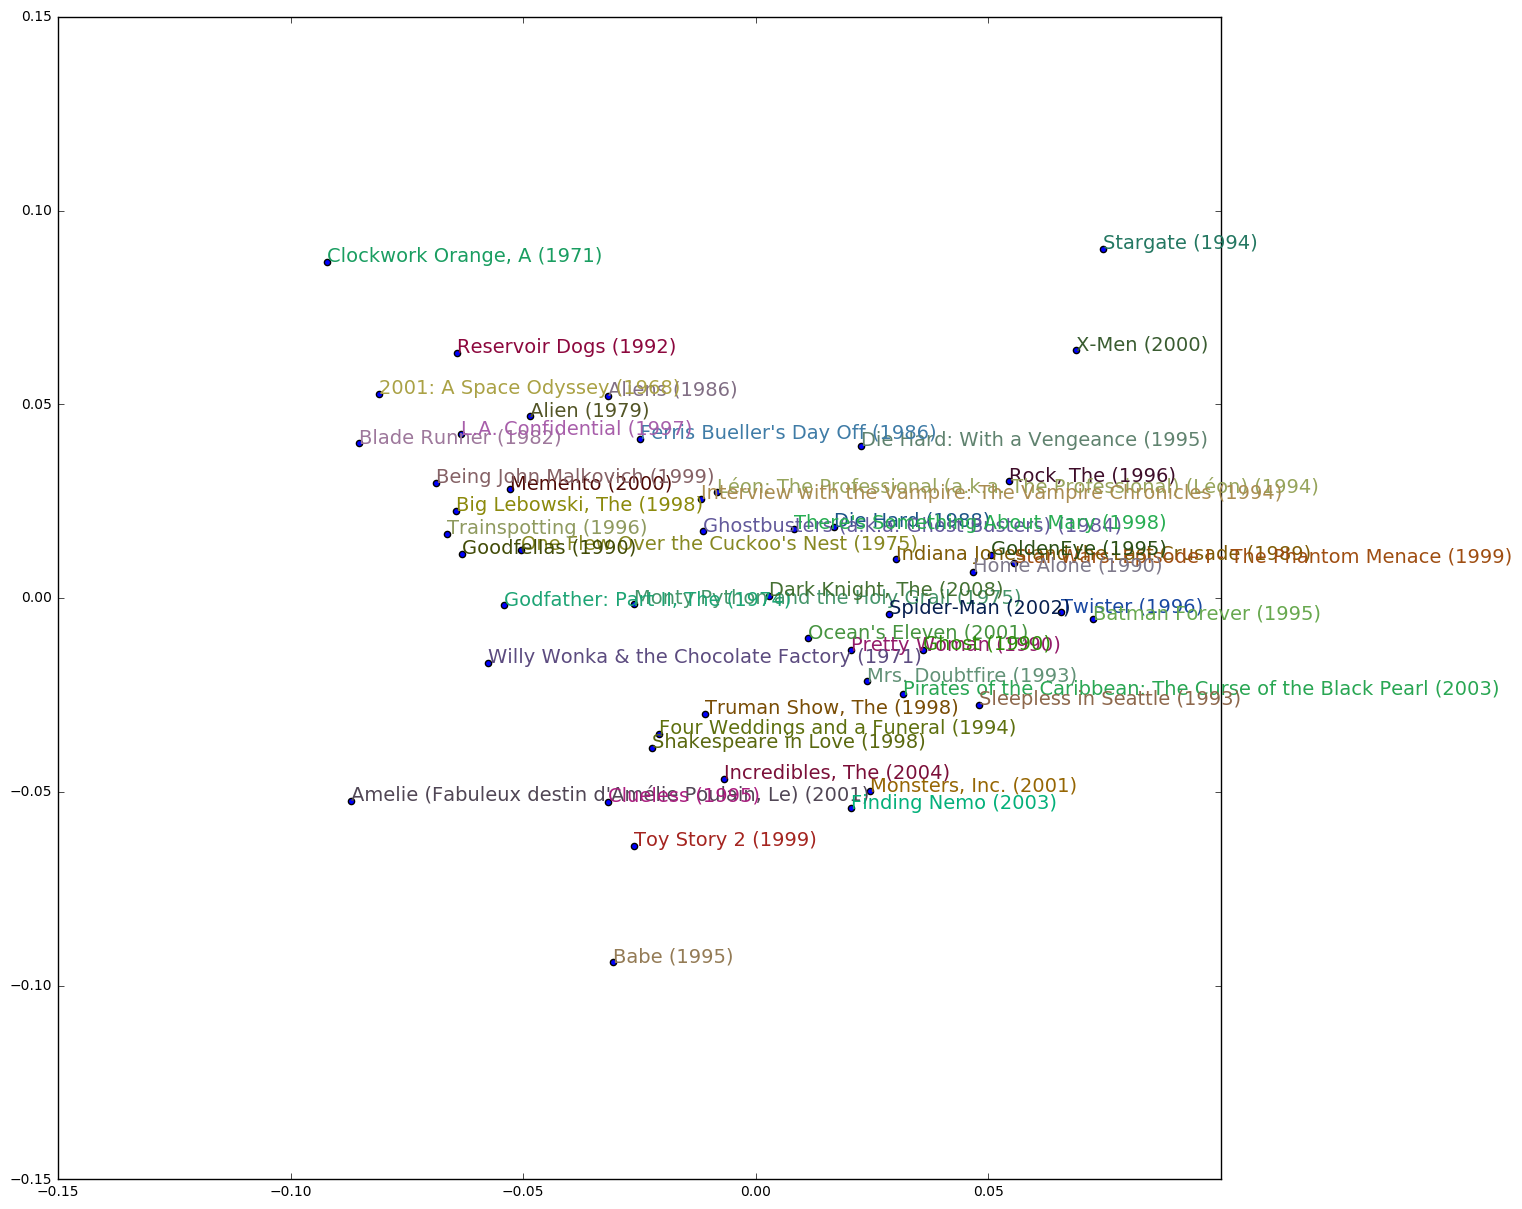

In [50]:
start = 50; end = 100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize = (15, 15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color = np.random.rand(3) * 0.7, fontsize = 14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [63]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [53]:
x = concatenate([u, m])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)

nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

Let's inspect the model

In [65]:
nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

In [ ]:
We then train the model

In [57]:
nn.fit(x = [trn.userId, trn.movieId],
       y = trn.rating,
       batch_size = batch_size,
       epochs = 8, 
       validation_data = ([val.userId, val.movieId], val.rating))

Train on 80118 samples, validate on 19886 samples
Epoch 1/8
80118/80118 [==============================] - 8s - loss: 3.2166 - val_loss: 1.1495
Epoch 2/8
80118/80118 [==============================] - 8s - loss: 1.6601 - val_loss: 1.0159
Epoch 3/8
80118/80118 [==============================] - 8s - loss: 1.3458 - val_loss: 0.9819
Epoch 4/8
80118/80118 [==============================] - 8s - loss: 1.1358 - val_loss: 0.9385
Epoch 5/8
80118/80118 [==============================] - 8s - loss: 1.0012 - val_loss: 0.9088
Epoch 6/8
80118/80118 [==============================] - 8s - loss: 0.9306 - val_loss: 0.8902
Epoch 7/8
80118/80118 [==============================] - 8s - loss: 0.8854 - val_loss: 0.8706
Epoch 8/8
80118/80118 [==============================] - 8s - loss: 0.8597 - val_loss: 0.8599


This improves on our already impressive accuracy even further!

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [58]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending = False)[:2000]
topMovies = np.array(topMovies.index)

We now cannot consider the bias terms. Only the embeddings.

In [59]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use PCA to simplify them down to just 3 vectors.

In [60]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
movie_pca = pca.fit(movie_emb.T).components_

In [61]:
fac0 = movie_pca[0]

In [62]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic' or small/independent.

In [63]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.055911861, 'Little Nicky (2000)'),
 (0.053322345, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.053098232, 'Super Mario Bros. (1993)'),
 (0.052093793, 'Police Academy 3: Back in Training (1986)'),
 (0.051634695, 'Speed 2: Cruise Control (1997)'),
 (0.051520299, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (0.050677847, 'Avengers, The (1998)'),
 (0.050658923, 'Bio-Dome (1996)'),
 (0.048714697, 'Superman IV: The Quest for Peace (1987)'),
 (0.047654651,
  'Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994)')]

In [64]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.071188733, 'Godfather, The (1972)'),
 (-0.064554363, 'Shawshank Redemption, The (1994)'),
 (-0.058538198, 'Roger & Me (1989)'),
 (-0.057988402, 'Godfather: Part II, The (1974)'),
 (-0.057854913, 'Band of Brothers (2001)'),
 (-0.057141054, 'Crimes and Misdemeanors (1989)'),
 (-0.056284793, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (-0.055561598, 'All About Eve (1950)'),
 (-0.055469397, "Schindler's List (1993)"),
 (-0.053944241, 'Usual Suspects, The (1995)')]

In [66]:
fac1 = movie_pca[1]

In [67]:
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [68]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.14280222, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (0.13676122, 'Jurassic Park (1993)'),
 (0.12755628, 'Titanic (1997)'),
 (0.10283071, 'Star Wars: Episode II - Attack of the Clones (2002)'),
 (0.1014774, 'Batman (1989)'),
 (0.092565842, 'Cocoon (1985)'),
 (0.092314541, 'Silence of the Lambs, The (1991)'),
 (0.091223612, 'Austin Powers: The Spy Who Shagged Me (1999)'),
 (0.085298702, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (0.085195653, 'Arachnophobia (1990)')]

In [69]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.070142262, 'Space Jam (1996)'),
 (-0.066626385, 'Like Water for Chocolate (Como agua para chocolate) (1992)'),
 (-0.06644696, 'Avengers, The (1998)'),
 (-0.062670603, 'Speed 2: Cruise Control (1997)'),
 (-0.058776323, "Amelie (Fabuleux destin d'Am\xc3\xa9lie Poulain, Le) (2001)"),
 (-0.056092095, 'Shrek (2001)'),
 (-0.054136824, 'Mission to Mars (2000)'),
 (-0.054056838, 'Dodgeball: A True Underdog Story (2004)'),
 (-0.052380752, 'Trainspotting (1996)'),
 (-0.050010152, 'Super Mario Bros. (1993)')]

In [70]:
fac2 = movie_pca[2]

In [71]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'. Or more likely kid friendly vs. not that.

In [72]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.16657156, 'Pulp Fiction (1994)'),
 (0.14537553, 'Fargo (1996)'),
 (0.095337659, 'American Psycho (2000)'),
 (0.083083197, 'Lost in Translation (2003)'),
 (0.080251656, 'Taxi Driver (1976)'),
 (0.079606466, 'Leaving Las Vegas (1995)'),
 (0.077931777, 'Demolition Man (1993)'),
 (0.077229939, 'Natural Born Killers (1994)'),
 (0.07665582, 'Get Shorty (1995)'),
 (0.072832845, 'American Beauty (1999)')]

In [73]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.15096974, 'Titanic (1997)'),
 (-0.13488705, 'Saving Private Ryan (1998)'),
 (-0.13444814, 'Shrek (2001)'),
 (-0.12608454, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.11501482, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.11449153, 'Babe (1995)'),
 (-0.10716758, 'Monsters, Inc. (2001)'),
 (-0.1020674, 'Star Trek IV: The Voyage Home (1986)'),
 (-0.098800883, 'Speed (1994)'),
 (-0.093133539, 'Toy Story (1995)')]